# Support Vector Machines

Using support vector machines (SVMs) is a great way to separate labelled data. A SVM is a type of classifier that separates data by finding the optimal linear (or nonlinear) boundary between classes using separating hyperplanes. Specifying the slack budget C around the margin of the hyperplane allows one to tune the SVM's flexibility, while using Kernel functions to lift the SVM into higher spaces allows one to separate classes by nonlinear boundaries.   

In [54]:
#Data Wrangling
import numpy as np
import pandas as pd

#Simulation
import random

#Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

#SVM
from sklearn.svm import SVR, SVC

#Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold, GridSearchCV

%matplotlib inline

In [106]:
# We'll define a function to draw a nice plot of an SVM
def plot_svc(svc, X, y, h=0.02, pad=0.25):
    """
    X: the input data points, in this case, rows are data points, and columns are features (X1, X2).
    y: target labels (1 or -1) for the data points in X.
    h: step size, the spacing between points in the grid.
    pad: Padding, it adds a small margin around the plotted data.
    
    """ 
    x_min, x_max = X[:, 0].min()-pad, X[:, 0].max()+pad  # get X's range
    y_min, y_max = X[:, 1].min()-pad, X[:, 1].max()+pad  # get y's range
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    """
    NOTE:
    X[:, 0].min() gets feature X1's MIN
    X[:, 1].max() gets feature X2's MAX
    -pad +pad can add a bit of extra space to the plot boundaries for better visualization.
    e.g. if X1 range [0, 5] and pad=0.25, MIN-pad MAX+pad 
    X1 updated range -> [-0.25, 5.25]
    
    NOTE:
    np.arange(start-inclusive, stop-exclusive, step) generates evenly spaced sequences of numbers from MIN to MAX with a step size of h.
    E.g.: 
    X1 = np.arange(-2, 2, 1)  # Feature X1: [-2, -1, 0, 1]
    X2 = np.arange(0, 2, 1)   # Feature X2: [0, 1]
    
    NOTE:
    np.meshgrid(x_range, y_range) generates a 2D grid 
    x_range: A 1D array representing coordinates along the x-axis.
    y_range: A 1D array representing coordinates along the y-axis.
    np.meshgrid()'s output: xx, yy, representing x-coordinates and y-coordinates of the grid.
    (If we consider X1 as x-axis and X2 as y-axis, then grid's coordinates will have a number of columns equal to the length of X1 and a number of rows equal to the length of X2:)
    xx (x-coordinates of the grid)>>>
    [[-2 -1  0  1]
     [-2 -1  0  1]]
    yy (y-coordinates of the grid)>>>
     [[0 0 0 0]
     [1 1 1 1]]
    """
    Z = svc.predict(np.c_[xx.ravel(), yy.ravel()]) 
    Z = Z.reshape(xx.shape) #returns a contiguous flattened array
    """
    NOTE:
    xx.ravel() and yy.ravel(): Flatten the 2D arrays xx and yy into 1D NumPy array.
    E.g.: 
    xx.ravel():
    [-2 -1  0  1 -2 -1  0  1]
    yy.ravel():
    [ 0  0  0  0  1  1  1  1]
    
    NOTE:
    np.c_ combines xx and yy arrays into grid point [x, y].
    E.g.: 
    xx.ravel() = [x1, x2, x3, ..., xn]
    yy.ravel() = [y1, y2, y3, ..., yn]
    np.c_[xx.ravel(), yy.ravel()] >>>
    [[x1, y1]
     [x2, y2]
     [x3, y3]
     ...
     [xn, yn]]
    In this case, np.c_[xx.ravel(), yy.ravel()] >>> (total 8 data points)
    [[-2  0]
     [-1  0]
     [ 0  0]
     [ 1  0]
     [-2  1]
     [-1  1]
     [ 0  1]
     [ 1  1]]

    NOTE:
    Z = svc.predict(X_test): gets SVM predictions from the testing data.
    >>>
    [1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1]
    
    NOTE:
    Z = Z.reshape(xx.shape)
    >>>
    [[ 1,  1, -1],
     [-1, -1,  1],
     [ 1,  1,  1],
     [-1, -1, -1]]    
    """
    
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.2)  # Draws the decision regions on the background using different colors for each class.
    plt.scatter(X[:,0], X[:,1], s=70, c=y, cmap=mpl.cm.Paired)  # Plots the data points on top of the decision regions, with colors representing data point's class labels.
    """
    NOTE:
    plt.contourf(xx, yy, Z, levels=None, cmap=None, **kwargs) creates a filled contour plot:
    xx and yy: x- and y-coordinates of the grid.
    Z: 2D array of predicted labels, each for a grid data point.
    cmap=plt.cm.Paired: assigns colors to each class region.
    alpha=0.2: sets the transparency of the filled regions.
    """

    # Support vectors indicated in plot by vertical lines
    sv = svc.support_vectors_
    plt.scatter(sv[:,0], sv[:,1], c='k', marker='x', s=100, linewidths=1)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()
    print('Number of support vectors: ', svc.support_.size)

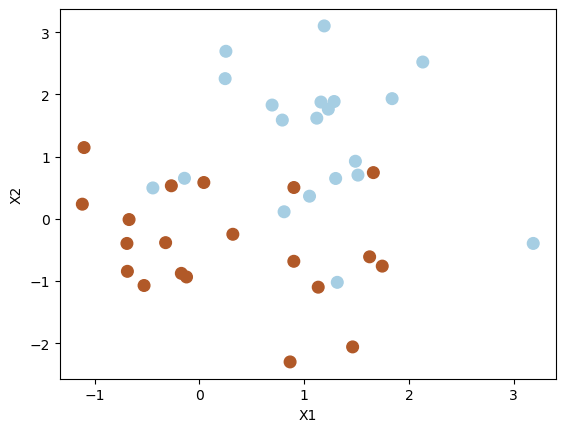

In [108]:
# Let's make some training data belonging to two classes that are not linearly separable
np.random.seed(1)
Xtrain = np.random.randn(40,2) # generate 40 random numbers with 2 feature (say X1, X2)
ytrain = np.repeat([1,-1], 20) # generate label [1,-1] for the 40 data points, "class 1" and "class -1"

Xtrain[ytrain == -1] = Xtrain[ytrain == -1] +1  # (X1, X2) -> (X1+1, X2+1): shifting "class -1" to the up right side by 1 unit
# NOTE: without shift, the data points of both "class 1" and "class -1" are randomly distributed around the center (0, 0).

plt.scatter(
    Xtrain[:,0], Xtrain[:,1],  # plots the first feature (X1) on the x-axis and the second feature (X2) on the y-axis.
    s=70,  # size of the points.
    c=ytrain,  # Colors the points based on ytrain (labels 1 or -1).
    cmap=mpl.cm.Paired  # discrete colormap to differentiate classes visually.
    )
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

## Support Vector Classifier

Note that C is a regularization parameter. The strength of the regularization is inversely proportional to the cost "budget" allocated for observations to be on the wrong side of their respective margins.

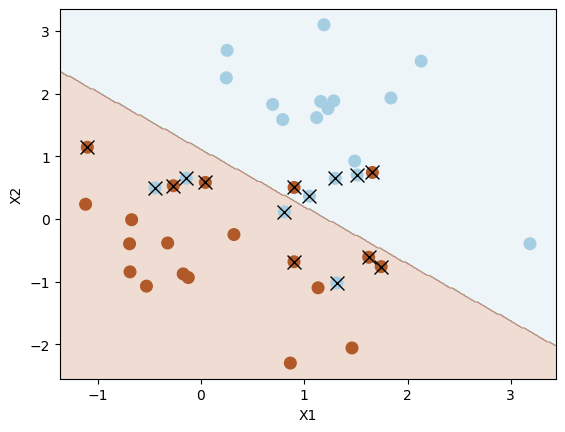

Number of support vectors:  15


In [114]:
# Let's fit a support vector classifier using a linear kernal (linear decision boundary)
svc = SVC(C=10, kernel='linear', random_state=1)
svc.fit(Xtrain, ytrain) # trains the model using the training data (Xtrain, train)

plot_svc(svc, Xtrain, ytrain)

In [116]:
# We can also get the indices of the support vectors with
svc.support_

array([20, 22, 25, 26, 31, 35, 37,  0,  3,  9, 10, 11, 12, 14, 19],
      dtype=int32)

In [120]:
# What happens if we use a much smaller cost value?
svc = SVC(C=0.1, kernel='linear', random_state=1)
svc.fit(Xtrain, ytrain)
svc.support_

array([20, 22, 25, 26, 27, 30, 31, 32, 34, 35, 37, 38,  0,  3,  4,  6,  7,
        9, 10, 11, 12, 14, 17, 19], dtype=int32)

Now that a smaller value of the cost parameter is being used, we obtain a larger number of support vectors, because the margin is now wider

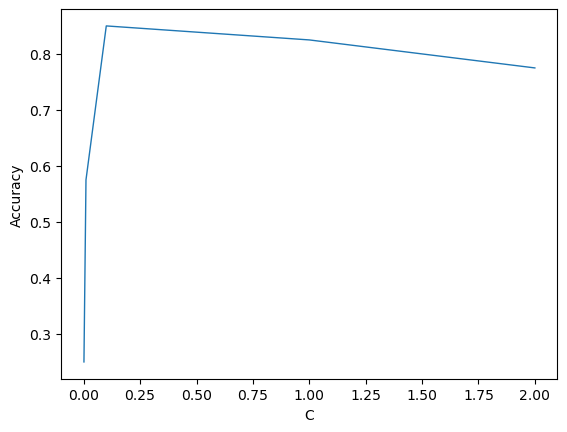

In [127]:
# Let's cross validate to find the optimal C
cs = [0.001, 0.01, 0.1, 1, 2]

accuracies = []
for c in cs:
    kaccuracies = []
    for trial in range(20):
        cv_method = KFold(n_splits=5,shuffle=True,random_state = int(c*1000)) # Define CV method. NOTE: Generates the same random seed for the same C
        model = SVC(C=c, kernel="linear",random_state=1)
        acc = np.mean(cross_val_score(model,Xtrain,ytrain,cv = cv_method,scoring = 'accuracy')) # cross_val_score() runs cross validation with a score and np.mean() calculate the average of 5 accuracy scores
        kaccuracies.append(acc)  # append 20 times
    accuracies.append(np.mean(kaccuracies))

plt.plot(cs, accuracies, linewidth=1)
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.show()

In [129]:
accuracies

[0.25, 0.5749999999999998, 0.85, 0.8249999999999998, 0.7750000000000001]

We see that cost=0.1 results in the lowest cross-validation error rate (highest accuracy).

In [138]:
# Now let's generate some test_data and predict using our classifier with c = 0.1

# Randomly generate test_data:
np.random.seed(2)
Xtest = np.random.randn(20,2)
ytest = np.repeat([1,-1], 10)
Xtest[ytest == -1] = Xtest[ytest == -1] +1

# create svc and train model with training data:
svc = SVC(C=0.1, kernel='linear', random_state=1)
svc.fit(Xtrain, ytrain)

# apply testing data and get the accuracy
print(accuracy_score(svc.predict(Xtest), ytest))

0.75


In [142]:
# Now predict using our classifier with c = 0.01:
svc = SVC(C=0.01, kernel='linear', random_state=1)
svc.fit(Xtrain, ytrain)
print(accuracy_score(svc.predict(Xtest), ytest))

0.6


In [144]:
# Now predict using our classifier with c = 1:
svc = SVC(C=1, kernel='linear', random_state=1)
svc.fit(Xtrain, ytrain)
print(accuracy_score(svc.predict(Xtest), ytest))

0.7


As we can see c=0.1 does the best with cross validation.

### Nonlinear Support Vector Machine

Next, we will use a nonlinear Kernel to separate boundaries.

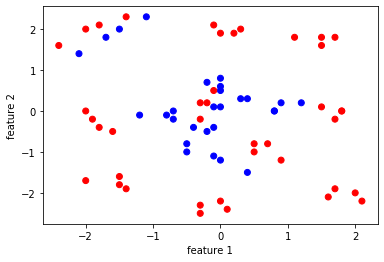

In [ ]:
# Training data
np.random.seed(5)
x1 = [-.7, 0, 0, .8, .3, -.2, -2, 0, 0, 1.8, -2, 1.5, 2, -1.5, 0.5, -1.5, -0.2]  # generate initial data for feature 1 (x1)
x1 += [x + 0.1 * random.randrange(-3,3) for x in x1]
x1 += [x + 0.1 * random.randrange(-5,5) for x in x1]  # add random noise twice, increasing the size of x1 threefold
x1 = np.array(x1)
x2 = [0, .8, -1.2, 0, .3, -.5, 0, 1.9, -2.2, 0, 2, 1.8, -2, -1.8, -.8, 2, 0.2]  # generate initial data for feature 2 (x2)
x2 += [x + 0.1* random.randrange(-2,2) for x in x2]
x2 += [x + 0.1* random.randrange(-4,4) for x in x2]  # add random noise twice, slightly different ranges for randomness comparing with X1
x2 = np.array(x2)
X = np.stack([x1,x2], axis=1)  # construct dataset, each point [feature1, feature2]
colors = ['b'] * 6 + ['r'] * 8 + ['r'] + ['b'] + ['r']  # create colors list for the initial data
colors += colors  
colors += colors  # extend list threefold to match the dataset size
y = [1] * 6 + [-1] * 8 + [-1] + [1] + [-1]  # assign labels for the positive and negative class
y += y
y += y # extend list threefold to match the dataset size

plt.scatter(x1, x2, c=colors)
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.show()

In [ ]:
# Note for polynomial kernal use kernal='poly'
# We use a radial kernal which seems most appropriate for the data seen

svm = SVC(C=1, kernel='rbf', gamma=1, random_state=1) 
svm.fit(X, y)
accuracy_score(svm.predict(X), y)

0.8676470588235294

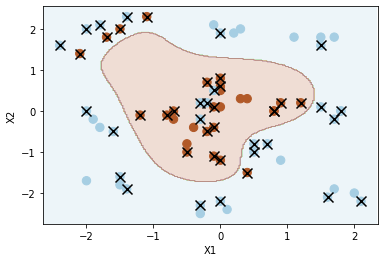

Number of support vectors:  45


In [ ]:
plot_svc(svm, X, y)

The SVM did a good job of creating nonlinear boundaries around the classes.

In [ ]:
# We shall cross validate to obtain the optimal values for gamma and cost
cs = [0.001, 0.01, 0.1, 1, 2]
gammas = [0.5, 1, 2, 3, 4]

accuracies = []
for gamma in gammas:
    for c in cs:
        kaccuracies = []
        for trial in range(20):
            cv_method = KFold(n_splits=5,shuffle=True,random_state = int(gamma*2)) #Define CV method
            model = SVC(C=c, kernel="rbf", gamma=gamma, random_state=1)
            accuracy = np.mean(cross_val_score(model,X,y,cv = cv_method,scoring = 'accuracy')) #Run cross validation with a score
            kaccuracies.append(accuracy)
        accuracies.append({'c': c, 'gamma': gamma, 'accuracy': np.mean(kaccuracies)})


# Find the max accuracy
for accuracy in accuracies:
    print('cost:', accuracy['c'], 'gamma:', accuracy['gamma'], 'accuracy:', accuracy['accuracy'])

cost: 0.001 gamma: 0.5 accuracy: 0.5890109890109889
cost: 0.01 gamma: 0.5 accuracy: 0.5890109890109889
cost: 0.1 gamma: 0.5 accuracy: 0.5736263736263736
cost: 1 gamma: 0.5 accuracy: 0.7637362637362635
cost: 2 gamma: 0.5 accuracy: 0.764835164835165
cost: 0.001 gamma: 1 accuracy: 0.5857142857142856
cost: 0.01 gamma: 1 accuracy: 0.5857142857142856
cost: 0.1 gamma: 1 accuracy: 0.5857142857142856
cost: 1 gamma: 1 accuracy: 0.7637362637362635
cost: 2 gamma: 1 accuracy: 0.764835164835165
cost: 0.001 gamma: 2 accuracy: 0.5868131868131867
cost: 0.01 gamma: 2 accuracy: 0.5868131868131867
cost: 0.1 gamma: 2 accuracy: 0.5868131868131867
cost: 1 gamma: 2 accuracy: 0.7824175824175825
cost: 2 gamma: 2 accuracy: 0.752747252747253
cost: 0.001 gamma: 3 accuracy: 0.5912087912087911
cost: 0.01 gamma: 3 accuracy: 0.5912087912087911
cost: 0.1 gamma: 3 accuracy: 0.5912087912087911
cost: 1 gamma: 3 accuracy: 0.80989010989011
cost: 2 gamma: 3 accuracy: 0.8549450549450549
cost: 0.001 gamma: 4 accuracy: 0.589010

We see a cost value of 2 and gamma of 3 result in the best cross validation results. Because writing for loops is not very efficient, we can use GridSearchCV to run hyper-parameter optimization tuning for our model. GridSearchCV runs through the parameters of interest and shows the parameters that optimize the model.

In [ ]:
# Alternativey, we could just use the GridSearchCV method
# K-Fold Cross-Validation: perform cross-validation to find the best parameters c and gamma and avoid overfitting. In the K-Fold Cross-Validation, the dataset is divided into 5 parts (using KFold(n_splits=5)), with 4 parts for training and 1 part for testing. This process is repeated 5 times, each time using a different fold as the testing set.

param_grid = {'C': cs, 'gamma': gammas}
clf = GridSearchCV(estimator=SVC(kernel='rbf',random_state=1), 
    param_grid=param_grid, scoring='accuracy') #Defaults to 5-fold CV
clf.fit(X, y)
clf.best_params_

{'C': 1, 'gamma': 0.5}

Interestingly, the two methods yield different results. This is most likely due to the randomness of how the data was generated which thus results in high variance between the cross validation splits.

### ROC Curves

Let's assess the accuracy of two SVM models with two different values of gamma using ROC curves.

In [ ]:
# Function to plot ROC using test data
def plot_roc(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test))  # x-axis (FPR) y-axis (TPR) : plot 5 points
    plt.figure()  # creates an additional figure object
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()  # Displays the ROC curve
    
    return fpr, tpr, thresholds

In [ ]:
# Lets split the data into test and train
data =  np.stack([x1, x2, y], axis=1)
# NOTE：
# stack the x1, x2, y into a 2D NumPy array
# e.g.:
# x1 = [0.5, -0.2, 1.3]
# x2 = [1.0, -0.8, 0.7]
# y = [1, -1, 1]
# data >>>
# ([[ 0.5,  1. ,  1. ],
# [-0.2, -0.8, -1. ],
# [ 1.3,  0.7,  1. ]])
train, test = train_test_split(data,test_size=0.2, random_state=1)  # 20% testing set, 80% training set

# NOTE:
# Transpose: from each row represents single data point to a feature (x1 x2) or label (y)
train = np.transpose(train)
test = np.transpose(test)
X_train = np.transpose(train[0:2])  # extracts feature (x1 x2)
y_train = train[2]  # extracts label (y)
X_test = np.transpose(test[0:2])
y_test = test[2]

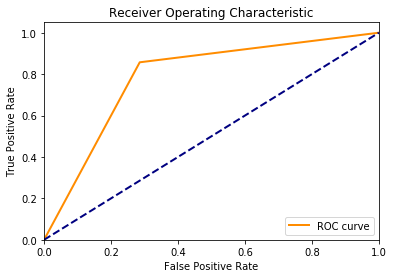

In [ ]:
# Gamma = 4 SVM
gamma4 = 4
svm = SVC(C=2, kernel='rbf', gamma=gamma4, random_state=1) 

fpr, tpr, thresholds = plot_roc(svm, X_train, y_train, X_test, y_test)

In [ ]:
print('The area under the ROC curve for an svm with C=2, gamma=',gamma4, 'is', auc(fpr, tpr))

The area under the ROC curve for an svm with C=2, gamma= 4 is 0.7857142857142858


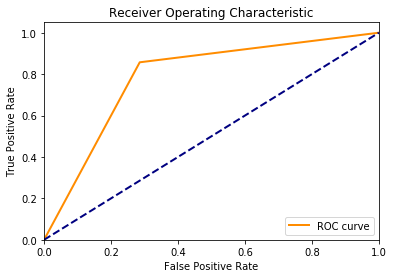

In [ ]:
# Gamma = 3 SVM
gamma3 = 3
svm = SVC(C=2, kernel='rbf', gamma=gamma3, random_state=1) 

fpr, tpr, thresholds = plot_roc(svm, X_train, y_train, X_test, y_test)

In [ ]:
print('The area under the ROC curve for an svm with C=2, gamma=',gamma3, 'is', auc(fpr, tpr))

The area under the ROC curve for an svm with C=2, gamma= 3 is 0.7857142857142858


A gamma of 3 seems to produce the more accurate results

### SVM with Multiple Classes

Note that the svm.SVC and SVR handle multiple classes with a one-to-one scheme

In [ ]:
# Let's add a new y with three classes now
y = [1] * 3 + [0] * 3 + [-1] * 4 + [0] * 4 + [-1] + [0] + [-1]  # three classes: -1 0 1
y += y
y += y

svm = SVC(C=2, kernel='rbf', gamma=gamma, random_state=1)
svm.fit(X, y)
accuracy_score(svm.predict(X), y)

0.9705882352941176

In [ ]:
svm.predict(X)

array([ 1,  1,  1,  0,  0,  0, -1, -1, -1, -1,  0,  0,  0,  0, -1,  0, -1,
        1,  1,  1,  0,  0,  0, -1, -1, -1, -1,  0,  0,  0,  0, -1,  0, -1,
        1,  1,  1,  0,  0,  0, -1, -1, -1, -1,  0,  0,  0,  0, -1,  0,  0,
        1,  1,  1,  0,  0,  0, -1, -1, -1, -1,  0,  0,  0,  0, -1,  0,  1])